In [1]:
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
attention_dot = [11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
draw_line = [[11, 13], [13, 15], [12, 14], [14, 16], [23, 25], [25, 27],
             [24, 26], [26, 28], [11, 12], [11, 23], [23, 24], [12, 24]]

def show_skeleton(video_path , interval, attention_dot, draw_line):
    xy_list_list, xy_list_list_flip = [], []
    cv2.destroyAllWindows()
    pose = mp_pose.Pose(static_image_mode = True, model_complexity = 1, enable_segmentation = False, min_detection_confidence = 0.3)
    cap = cv2.VideoCapture(video_path)
    
    if cap.isOpened():
        cnt = 0
        while True:
            ret, img = cap.read()
            if cnt == interval and ret == True:
                cnt = 0
                xy_list, xy_list_flip = [], []
                img = cv2.resize(img, (640,  640))
                results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if not results.pose_landmarks: continue
                idx = 0
                draw_line_dic = {}
                for x_and_y in results.pose_landmarks.landmark:
                    if idx in attention_dot:
                        xy_list.append(x_and_y.x)
                        xy_list.append(x_and_y.y)
                        xy_list_flip.append(1 - x_and_y.x)
                        xy_list_flip.append(x_and_y.y)
                        x, y = int(x_and_y.x * 640), int(x_and_y.y * 640)
                        draw_line_dic[idx] = [x, y]
                    idx += 1
                xy_list_list.append(xy_list)
                xy_list_list_flip.append(xy_list_flip)
                for line in draw_line:
                    x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
                    x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
                    img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)
                cv2.imshow('Landmark Image', img)
                cv2.waitKey(1)
            elif ret == False: break
            cnt += 1
    cap.release()
    cv2.destroyAllWindows()
    
    return xy_list_list + xy_list_list_flip


In [2]:
import os
import random

video_path = '../data/train/'
video_name_list = os.listdir(video_path)
dataset = []
length = 20
interval = 1
for video_name in video_name_list:
    if 'nothing' in video_name: label = 0
    else: label = 1
    skel_data = show_skeleton('{}/{}'.format(video_path, video_name), interval, attention_dot, draw_line)
    for idx in range(0, len(skel_data), int(length/2)):
        seq_list = skel_data[idx : idx + length]
        if len(seq_list) == length:
            dataset.append({'key' : label, 'value' : seq_list})
random.shuffle(dataset)

I0000 00:00:1700631576.609268    4733 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1700631576.612219    4901 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1700631604.474911    4733 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1700631604.475672    4941 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)


In [3]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print("GPU is available")
else:
    device = 'cpu'
    print('GPU is unavailable')

GPU is available


In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list:
            self.y.append(dic['key'])
            self.X.append(dic['value'])
        
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))
    
    def __len__(self):
        return len(self.X)

In [5]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(dataset) * split_ratio[0])
val_len = int(len(dataset) * split_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

78, 9, 11


In [6]:
from torch.utils.data import random_split
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size = 8)
val_loader = DataLoader(valid_data, batch_size = 8)
test_loader = DataLoader(test_data, batch_size = 8)

In [7]:
class skeleton_LSTM(nn.Module):
    def __init__(self):
        super(skeleton_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=24, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:, -1, :])
        
        return x

In [8]:
import matplotlib.pyplot as plt
from torch.optim import Adam

def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = skeleton_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr = 0.0001)

def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [9]:
def record_train_log(_tloss, _tacc, _time):
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환 (print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1
    
from IPython.display import clear_output
def print_log():
    # 학습 추이 출력

    # 소주점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 2)

    log_str = 'Epoch: {:3}, | T_Loss {:5}, | T_acc {:5} | V_loss {:5} | V_acc {:5} | time {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str) # 프린트 준비

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정

    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line  # 위에서 선언한 plt 정볼들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid()  # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx]) 

In [10]:
import gc
from torch.cuda import memory_allocated, empty_cache

def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
import numpy as np
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘 (for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-Forward
        if mode == 'train':
            net.train()
        else:
            net.eval()   # 학습때만 쓰이는 Dropout, Batch Normalization을 미사용

        result = net(data)
        _, out = torch.max(result, 1)

        # 2. loss 계산
        loss = loss_fn(result, label)
        iter_loss.append(loss.item())  # 학습 추이를 위하여 loss 기록

        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    return np.average(iter_loss), np.average(iter_acc)




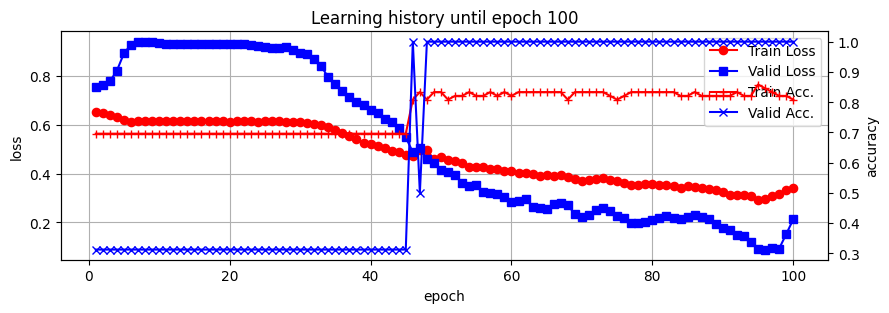

Epoch: 100, | T_Loss 0.339, | T_acc 0.808 | V_loss 0.212 | V_acc   1.0 | time  0.21
Epoch:  99, | T_Loss 0.333, | T_acc 0.821 | V_loss 0.152 | V_acc   1.0 | time  0.19
Epoch:  98, | T_Loss 0.317, | T_acc 0.821 | V_loss 0.093 | V_acc   1.0 | time  0.19
Epoch:  97, | T_Loss 0.308, | T_acc 0.833 | V_loss 0.097 | V_acc   1.0 | time   0.2
Epoch:  96, | T_Loss 0.294, | T_acc 0.846 | V_loss 0.089 | V_acc   1.0 | time   0.2
Epoch:  95, | T_Loss 0.291, | T_acc 0.858 | V_loss 0.091 | V_acc   1.0 | time  0.19
Epoch:  94, | T_Loss 0.308, | T_acc 0.821 | V_loss 0.118 | V_acc   1.0 | time   0.2
Epoch:  93, | T_Loss 0.311, | T_acc 0.821 | V_loss 0.144 | V_acc   1.0 | time  0.19
Epoch:  92, | T_Loss 0.314, | T_acc 0.833 | V_loss 0.148 | V_acc   1.0 | time   0.2
Epoch:  91, | T_Loss 0.313, | T_acc 0.821 | V_loss 0.169 | V_acc   1.0 | time  0.19
Epoch:  90, | T_Loss 0.323, | T_acc 0.821 | V_loss 0.178 | V_acc   1.0 | time  0.19
Epoch:  89, | T_Loss 0.331, | T_acc 0.821 | V_loss 0.195 | V_acc   1.0 | tim

In [12]:
# Trainig Initialization
init_model()
init_epoch()
init_log()
maximum_epoch = 100

def epoch_not_finished():
    return epoch_cnt < maximum_epoch

# Training Iteration
import time
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training Completed')

In [13]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc. : {}'.format(test_acc))
    print('Test Loss : {}'.format(test_loss))

Test Acc. : 0.8125
Test Loss : 0.5263


In [14]:
video_path = '../data/test/test_sample_apple.mp4'
cv2.destroyAllWindows()
cap = cv2.VideoCapture(video_path)
img_list = []

if cap.isOpened():
    cnt = 0
    while True:
        ret, img = cap.read()
        if ret:
            img = cv2.resize(img, (640, 640))
            if cnt == interval:
                img_list.append(img)
                cnt = 0
            cv2.imshow(video_name, img)
            cv2.waitKey(1)
            cnt += 1
        else:
            break
cap.release()
cv2.destroyAllWindows()
print('저장된 frame의 개수 : {}'.format(len(img_list)))

저장된 frame의 개수 : 451


In [15]:
from tqdm import tqdm
net.eval()
out_img_list = []
dataset = []
status = 'None'
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1,
                    enable_segmentation = False, min_detection_confidence=0.3)

print("시퀀스 데이터 분석 중...")

xy_list_list = []
for img in tqdm(img_list):
    results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks: continue
    xy_list = []
    idx = 0
    draw_line_dic = {}
    for x_and_y in results.pose_landmarks.landmark:
        if idx in attention_dot:
            xy_list.append(x_and_y.x)
            xy_list.append(x_and_y.y)
            x, y = int(x_and_y.x * 640), int(x_and_y.y * 640)
            draw_line_dic[idx] = [x, y]
        idx += 1
    xy_list_list.append(xy_list)
    for line in draw_line:
        x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
        x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
        img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)
    if len(xy_list_list) == length:
        dataset = []
        dataset.append({'key' : 0, 'value' : xy_list_list})
        dataset = MyDataset(dataset)
        dataset = DataLoader(dataset)
        xy_list_list = []
        for data, label in dataset:
            data = data.to(device)
            with torch.no_grad():
                result = net(data)
                _, out = torch.max(result, 1)
                if out.item() == 0: status = 'nothing'
                else: status = 'picking'
    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    out_img_list.append(img)

I0000 00:00:1700632069.540141    4733 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1700632069.542142    5189 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)


시퀀스 데이터 분석 중...


100%|██████████| 451/451 [00:36<00:00, 12.29it/s]


In [16]:
filename = '../output_video/video_out_apple.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 30
frameSize = (640, 640)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
